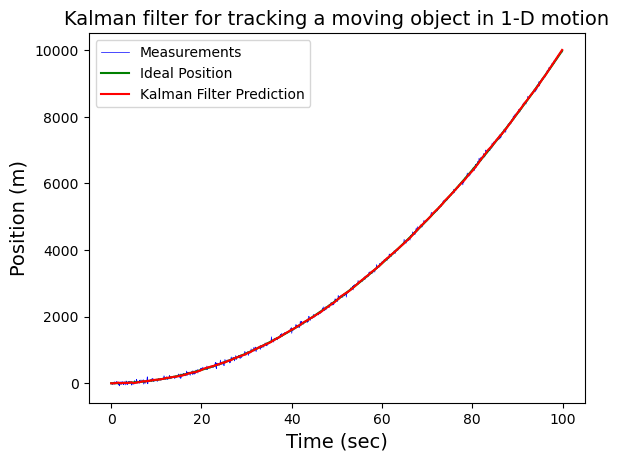

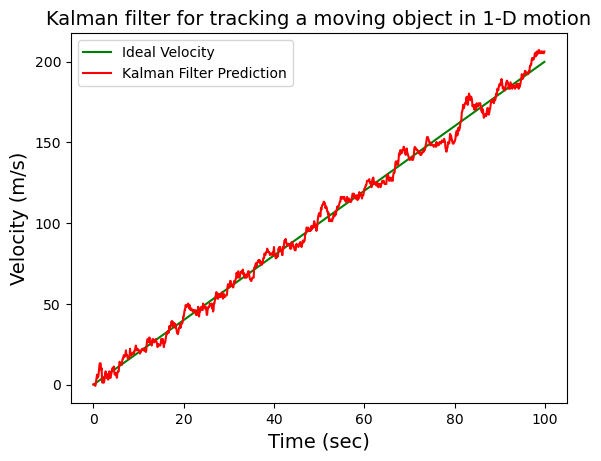

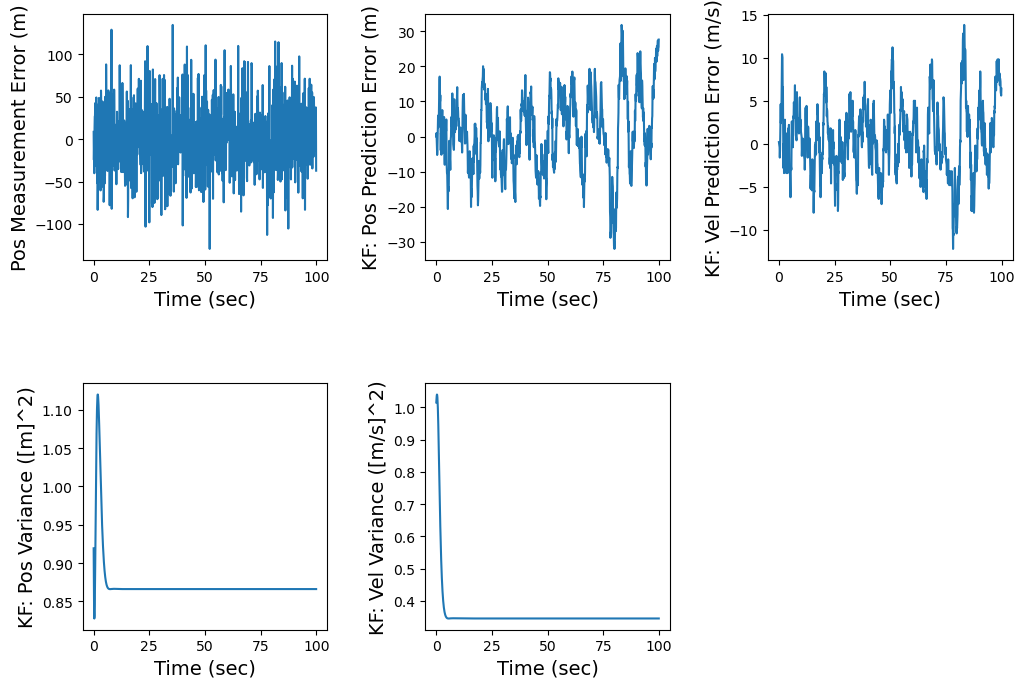

In [4]:
import numpy as np
import matplotlib.pyplot as plt

class KalmanFilter(object):
    def __init__(self, dt, u, std_acc, std_meas):
        self.dt = dt # discrete time step (Unit: sec)
        self.u = u # discrete input (Unit: m/s^2)
        self.std_acc = std_acc # standard deviation of the acceleration
        self.A = np.matrix([[1, self.dt], # State Transition Matrix : A ------------------
                            [0, 1]])
        self.B = np.matrix([[(self.dt**2)/2], [self.dt]]) # Control Input Matrix : B ----- 
        self.H = np.matrix([[1,0]]) # Transformation matrix : H --------------------------
        # Process noise covariance Matrix : Q
        self.Q = np.matrix([[(self.dt**4)/4, (self.dt**3)/2],
                            [(self.dt**3)/2, self.dt**2]]) * self.std_acc**2
        # Measurement noise covariance Matrix : R
        self.R = std_meas**2
        self.P = np.eye(self.A.shape[1]) # Initialize Error Covariance: P
        self.x = np.matrix([[0],[0]]) # Initialize State Vector : x
        
    def PredictUpdate(self):
        # Eq.(1): Prediction Update for state at each time step
        self.x = np.dot(self.A, self.x) + np.dot(self.B, self.u)
        # Eq.(2): Calculate Priori Error Covariance: P = A*P*A' + Q
        self.P = np.dot(np.dot(self.A, self.P), self.A.T) + self.Q
        return self.x
    
    def MeasurementUpdate(self, z):
        # Eq.(3): Measurement Update for compute Kalman Gain: S = H*P*H'+R 
        S = np.dot(self.H, np.dot(self.P, self.H.T)) + self.R
        # Eq.(3): Kalman Gain: K = P * H'* inv(H*P*H'+R)
        K = np.dot(np.dot(self.P, self.H.T), np.linalg.inv(S))  
        # Eq.(4): Calculate Posteriori State Estimate
        self.x = np.round(self.x + np.dot(K, (z - np.dot(self.H, self.x))))  
        # Eq.(5): Calculate Posteriori Error Covariance 
        I = np.eye(self.H.shape[1])
        self.P = (I - (K * self.H)) * self.P
        return self.P

dt = 0.1 # discrete time step (Unit: sec)
u= 2 # constant acceleration (Unit: m/s^2)
t = np.arange(0, 100, dt) # discrete time
Ideal_Motion = 0.5*u*(t**2) # generate an Ideal Motion Path
Ideal_Vel = u*t # generate an Ideal Velocity 

std_acc = 1.25    # the standard deviation of the acceleration (Unit: m/s^2)
std_meas = 3.2    # the standard deviation of the position measurement noise (Unit: m)
# create KalmanFilter object
kf = KalmanFilter(dt, u, std_acc, std_meas)

predictions = []  # initialize empty prediction update
predictPos = []   # initialize Position prediction
predictVel = []   # initialize Velocity prediction
measurements = [] # initialize empty measurement update
PosMeasurements = [] # initialize Position measurement 
ErrorCovPos = []  # intitialize empty priori error covariance of Position
ErrorCovVel = []  # intitialize empty priori error covariance of Velocity
i=0
for x in Ideal_Motion:
    # Mesurement at each time step
    z = (kf.H * x) + np.random.normal(0, 40)
    PosMeasurements.append(z.item(0))
    # Kalman Filter: Prediction Update
    predictions.append(kf.PredictUpdate())
    predictPos.append(predictions[i].item((0)))
    predictVel.append(predictions[i].item((1)))
    # Kalman Filter: Measurement Update
    measurements.append(kf.MeasurementUpdate(z.item(0)))
    ErrorCovPos.append(measurements[i].item(0,0))
    ErrorCovVel.append(measurements[i].item(1,1))
    i=i+1

MeasurementError = PosMeasurements - np.array(Ideal_Motion) 
KFPosPredictError = predictPos - np.array(Ideal_Motion)
KFVelPredictError = predictVel - np.array(Ideal_Vel) 
  
plt.figure(1)
plt.title('Kalman filter for tracking a moving object in 1-D motion', fontsize=14)
plt.plot(t, PosMeasurements, label='Measurements', color='b',linewidth=0.5)
plt.plot(t, np.array(Ideal_Motion), label='Ideal Position', color='g', linewidth=1.5)
plt.plot(t, predictPos, label='Kalman Filter Prediction', color='r', linewidth=1.5)
plt.xlabel('Time (sec)', fontsize=14), plt.ylabel('Position (m)', fontsize=14)
plt.legend()

plt.figure(2)
plt.title('Kalman filter for tracking a moving object in 1-D motion', fontsize=14)
plt.plot(t, np.array(Ideal_Vel), label='Ideal Velocity', color='g', linewidth=1.5)
plt.plot(t, predictVel, label='Kalman Filter Prediction', color='r', linewidth=1.5)
plt.xlabel('Time (sec)', fontsize=14), plt.ylabel('Velocity (m/s)', fontsize=14)
plt.legend()

plt.figure(3, figsize = (12,8))
plt.subplot(231), plt.plot(t, MeasurementError)
plt.xlabel('Time (sec)', fontsize=14), plt.ylabel('Pos Measurement Error (m)', fontsize=14)
plt.subplot(232), plt.plot(t, KFPosPredictError)
plt.xlabel('Time (sec)', fontsize=14), plt.ylabel('KF: Pos Prediction Error (m)', fontsize=14)
plt.subplot(233), plt.plot(t, KFVelPredictError)
plt.xlabel('Time (sec)', fontsize=14), plt.ylabel('KF: Vel Prediction Error (m/s)', fontsize=14)
plt.subplot(234), plt.plot(t, ErrorCovPos)
plt.xlabel('Time (sec)', fontsize=14), plt.ylabel('KF: Pos Variance ([m]^2)', fontsize=14)
plt.subplot(235), plt.plot(t, ErrorCovVel)
plt.xlabel('Time (sec)', fontsize=14), plt.ylabel('KF: Vel Variance ([m/s]^2)', fontsize=14)

# Adjust the layout to add space between subplots
plt.subplots_adjust(wspace=0.4, hspace=0.5)

plt.show()